In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!kaggle competitions download plant-pathology-2020-fgvc7

100% 779M/779M [00:50<00:00, 18.1MB/s]
100% 779M/779M [00:50<00:00, 16.3MB/s]


In [ ]:
!unzip plant-pathology-2020-fgvc7.zip

Archive:  plant-pathology-2020-fgvc7.zip
  inflating: images/Test_0.jpg       
  inflating: images/Test_1.jpg       
  inflating: images/Test_10.jpg      
  inflating: images/Test_100.jpg     
  inflating: images/Test_1000.jpg    
  inflating: images/Test_1001.jpg    
  inflating: images/Test_1002.jpg    
  inflating: images/Test_1003.jpg    
  inflating: images/Test_1004.jpg    
  inflating: images/Test_1005.jpg    
  inflating: images/Test_1006.jpg    
  inflating: images/Test_1007.jpg    
  inflating: images/Test_1008.jpg    
  inflating: images/Test_1009.jpg    
  inflating: images/Test_101.jpg     
  inflating: images/Test_1010.jpg    
  inflating: images/Test_1011.jpg    
  inflating: images/Test_1012.jpg    
  inflating: images/Test_1013.jpg    
  inflating: images/Test_1014.jpg    
  inflating: images/Test_1015.jpg    
  inflating: images/Test_1016.jpg    
  inflating: images/Test_1017.jpg    
  inflating: images/Test_1018.jpg    
  inflating: images/Test_1019.jpg    
  inflati

In [ ]:
import tensorflow as tf
from keras import models, layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import cv2
from tqdm import tqdm

In [ ]:
import random

In [ ]:
random.seed(30)

In [ ]:
img_dir="/content/images"
train_df=pd.read_csv("/content/train.csv")
train_df.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [ ]:
classes=list(train_df.columns)
classes.remove("image_id")
classes

['healthy', 'multiple_diseases', 'rust', 'scab']

In [ ]:
num=0
train_df["label"]=0
for i in classes:
    train_df["label"]=train_df["label"]+train_df[i]*num
    num=num+1
train_df

image_id  healthy  multiple_diseases  rust  scab  label
0        Train_0        0                  0     0     1      3
1        Train_1        0                  1     0     0      1
2        Train_2        1                  0     0     0      0
3        Train_3        0                  0     1     0      2
4        Train_4        1                  0     0     0      0
...          ...      ...                ...   ...   ...    ...
1816  Train_1816        0                  0     0     1      3
1817  Train_1817        1                  0     0     0      0
1818  Train_1818        1                  0     0     0      0
1819  Train_1819        0                  0     1     0      2
1820  Train_1820        0                  0     0     1      3

[1821 rows x 6 columns]

In [ ]:
labels=(train_df.label.value_counts())
labels

2    622
3    592
0    516
1     91
Name: label, dtype: int64

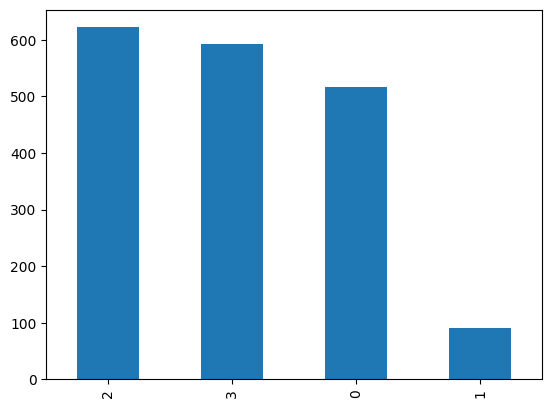

In [ ]:
labels.plot.bar(x=train_df.label, y=train_df.label.value_counts())
plt.show()

In [ ]:
#RUN THIS ONCE
#RUN THIS ONCE
shutil.os.mkdir("/content/train_data")
shutil.os.mkdir("/content/train_data/healthy")
shutil.os.mkdir("/content/train_data/multiple_diseases")
shutil.os.mkdir("/content/train_data/rust")
shutil.os.mkdir("/content/train_data/scab")

In [ ]:
def create_train_data():
    images=os.listdir(img_dir)
    for img in tqdm(images):
        if img[1]!='e':
            path=os.path.join(img_dir,img)
            img_num=int((img.split(".")[0])[6:])
            img_label=train_df.loc[img_num]["label"]
            
            if (img_label==0):
                shutil.copy(path,"/content/train_data/healthy/")
                
            elif (img_label==1):
                shutil.copy(path,"/content/train_data/multiple_diseases/")
                    
            elif (img_label==2):
                shutil.copy(path,"/content/train_data/rust/")
                    
            elif (img_label==3):
                shutil.copy(path,"/content/train_data/scab/")

In [ ]:
#RUN THIS ONCE
#RUN THIS ONCE
create_train_data()

100%|██████████| 3642/3642 [00:01<00:00, 3309.59it/s]


In [ ]:
#defining important constants
BATCH_SIZE=32
IMG_SIZE=256
CHANNELS=3

In [ ]:
#creating a tensor dataset with batch size=32 and image size=256X256
image_ds=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/train_data",
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE) ,
    batch_size=BATCH_SIZE   
)

Found 1821 files belonging to 4 classes.


In [ ]:
class_names=image_ds.class_names
len(class_names)

4

(32, 256, 256, 3)
[0 3 3 0 2 1 3 0 3 2 0 0 2 1 0 0 0 2 2 0 0 2 2 3 3 3 3 2 2 3 0 0]


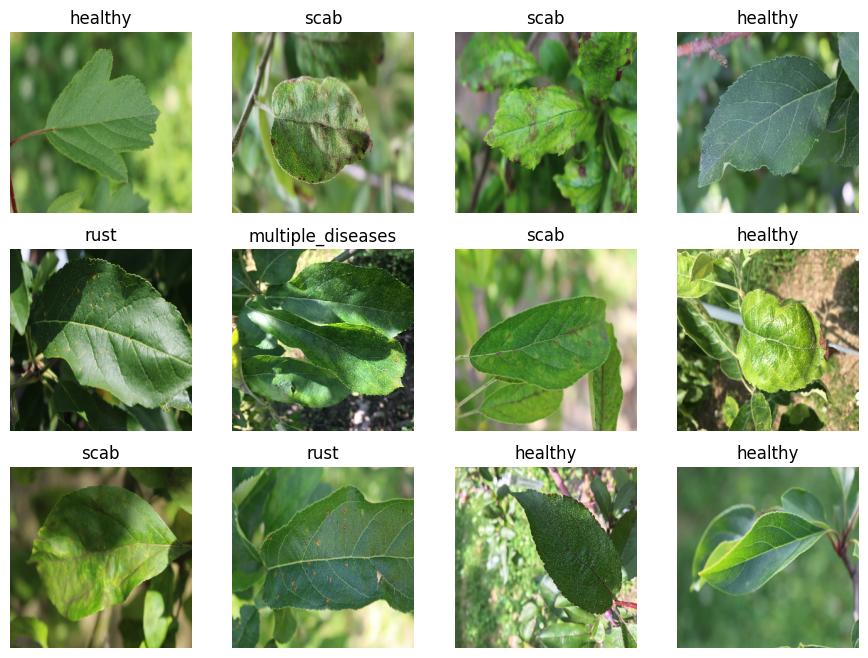

In [ ]:
plt.figure(figsize=(11,8))
for image_batch, labels_batch in image_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_partitions(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)

    return train_ds, val_ds

In [ ]:
train_ds, val_ds = get_partitions(image_ds)
print("train:",len(train_ds),", val:",len(val_ds))

train: 45 , val: 11


In [ ]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#### **MODEL TRAINING CNN**

In [ ]:
#stacking layers that resize and rescale the input image
resize_and_rescale=tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
        tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
    ]
)

In [ ]:
#augmenting data
data_augmentation=tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ]
)

In [ ]:
input_shape=(BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS)
model = tf.keras.models.Sequential(
    [
        resize_and_rescale,
        data_augmentation,
     
        layers.Conv2D(32, kernel_size=(3,3), activation='relu',input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2,2)),
        
        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
     
        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
     
        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
  
        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
     
        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
     
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(4, activation='softmax')        
    ]
)
model.build(input_shape=(BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
callback_hist = model.fit(
     train_ds,
     batch_size=BATCH_SIZE,
     epochs=50,
     validation_data=val_ds
     )

Epoch 1/50
45/45 [==============================] - 52s 496ms/step - loss: 1.2767 - accuracy: 0.3257 - val_loss: 1.2524 - val_accuracy: 0.3466
Epoch 2/50
45/45 [==============================] - 3s 62ms/step - loss: 1.2488 - accuracy: 0.3417 - val_loss: 1.1901 - val_accuracy: 0.3750
Epoch 3/50
45/45 [==============================] - 3s 62ms/step - loss: 1.0912 - accuracy: 0.5275 - val_loss: 0.8865 - val_accuracy: 0.6960
Epoch 4/50
45/45 [==============================] - 3s 63ms/step - loss: 0.8281 - accuracy: 0.6611 - val_loss: 0.7611 - val_accuracy: 0.6562
Epoch 5/50
45/45 [==============================] - 3s 65ms/step - loss: 0.6896 - accuracy: 0.6855 - val_loss: 0.7127 - val_accuracy: 0.6392
Epoch 6/50
45/45 [==============================] - 3s 62ms/step - loss: 0.6684 - accuracy: 0.7112 - val_loss: 0.6002 - val_accuracy: 0.7330
Epoch 7/50
45/45 [==============================] - 3s 63ms/step - loss: 0.5983 - accuracy: 0.7425 - val_loss: 0.5647 - val_accuracy: 0.7642
Epoch 8/50


In [ ]:
acc = callback_hist.history['accuracy']
val_acc = callback_hist.history['val_accuracy']
loss = callback_hist.history['loss']
val_loss = callback_hist.history['val_loss']

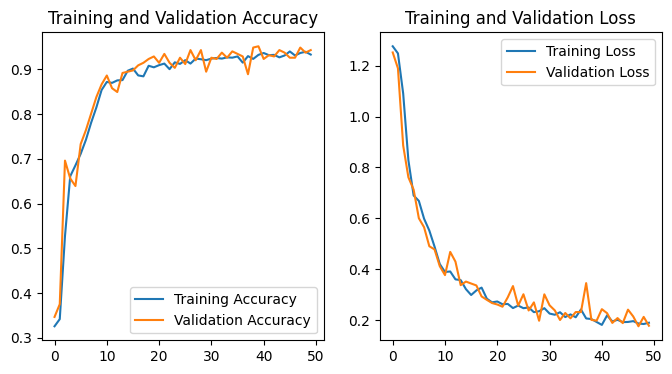

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: scab
1/1 [==============================] - 0s 143ms/step
predicted label: scab


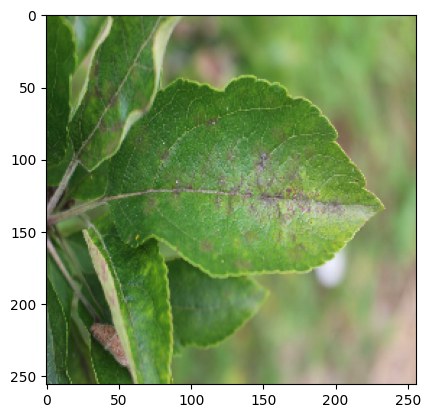

In [ ]:
import numpy as np
for images_batch, labels_batch in val_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


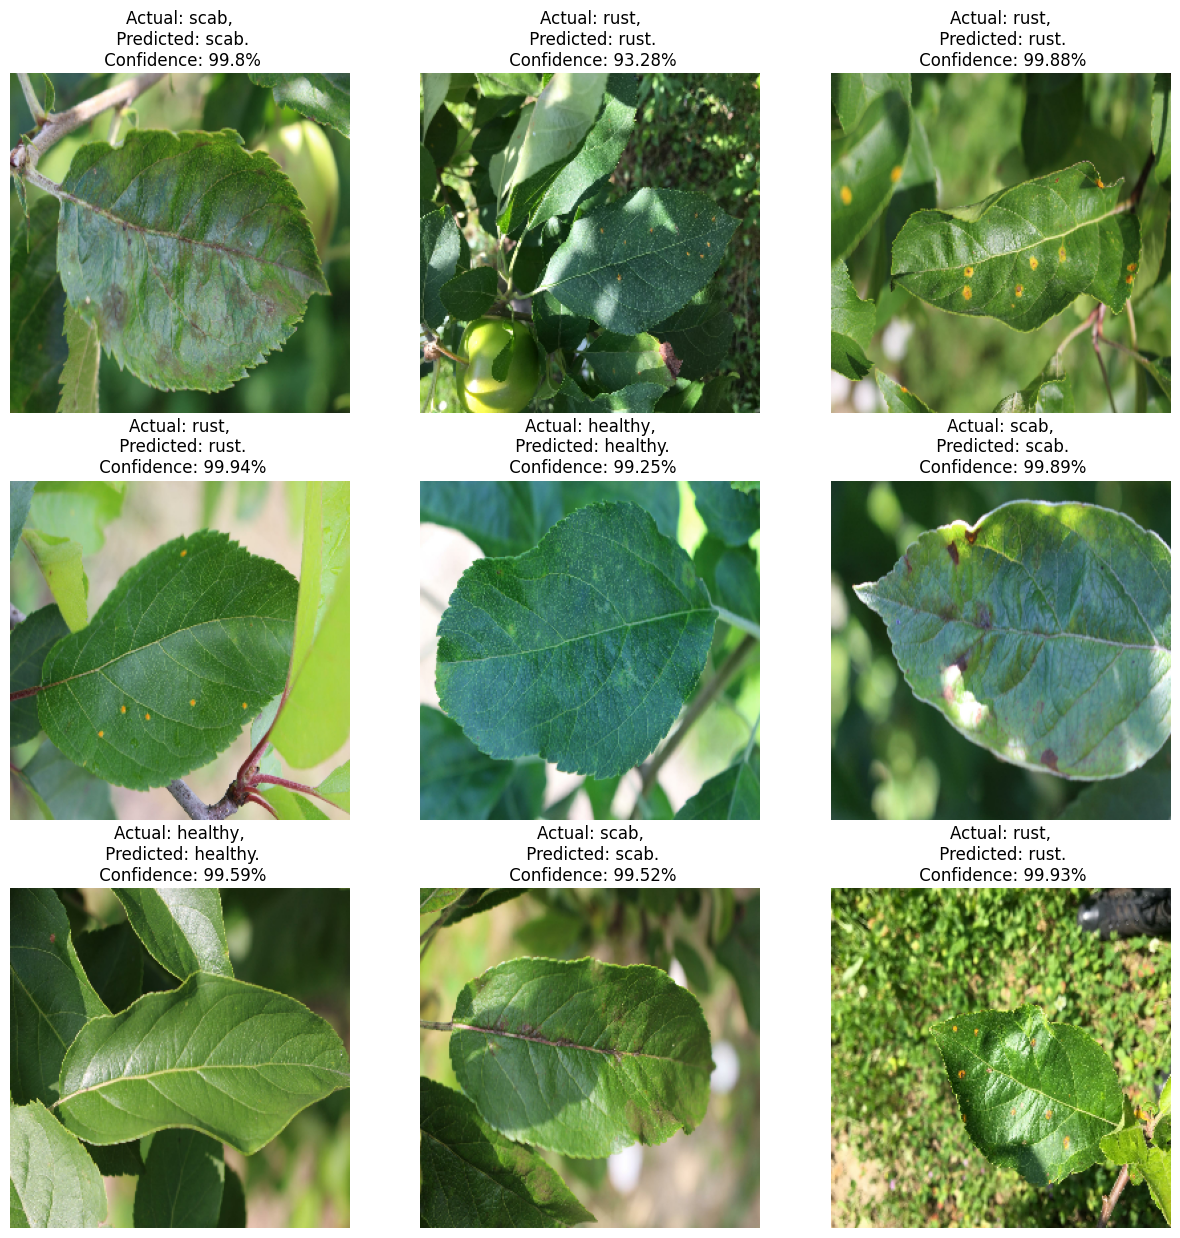

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### **MODEL TRAINING Xception**

In [ ]:
from keras.applications.xception import Xception

In [ ]:
xcept = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS)
)
xcept.trainable = False
print(xcept.summary())

83683744/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [ ]:
model_xcept = tf.keras.models.Sequential([
    resize_and_rescale,
    data_augmentation,
    xcept,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

In [ ]:
model_xcept.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')
model_xcept.build(input_shape=(BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS))
print(model_xcept.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten_1 (Flatten)         (32, 131072)              0         
                                                                 
 dense_2 (Dense)             (32, 4)                   524292    
                                                                 
Total params: 21,385,772
Trainable params: 524,292
Non-trainable params: 20,861,480
_________________________________________________________________
None


In [ ]:
callback_hist_Xception = model_xcept.fit(
     train_ds,
     batch_size=BATCH_SIZE,
     epochs=50,
     validation_data=val_ds
     )

Epoch 1/50
45/45 [==============================] - 18s 279ms/step - loss: 2.5599 - accuracy: 0.5866 - val_loss: 2.0021 - val_accuracy: 0.6705
Epoch 2/50
45/45 [==============================] - 9s 203ms/step - loss: 1.6968 - accuracy: 0.7098 - val_loss: 1.9940 - val_accuracy: 0.7216
Epoch 3/50
45/45 [==============================] - 9s 205ms/step - loss: 1.5218 - accuracy: 0.7411 - val_loss: 2.3677 - val_accuracy: 0.6705
Epoch 4/50
45/45 [==============================] - 9s 204ms/step - loss: 1.3303 - accuracy: 0.7711 - val_loss: 1.3466 - val_accuracy: 0.8068
Epoch 5/50
45/45 [==============================] - 9s 201ms/step - loss: 1.3860 - accuracy: 0.7578 - val_loss: 1.2466 - val_accuracy: 0.8182
Epoch 6/50
45/45 [==============================] - 9s 200ms/step - loss: 1.3965 - accuracy: 0.7711 - val_loss: 1.4887 - val_accuracy: 0.8182
Epoch 7/50
45/45 [==============================] - 9s 199ms/step - loss: 1.4304 - accuracy: 0.7815 - val_loss: 1.0169 - val_accuracy: 0.8125
Epoch

In [ ]:
acc_x = callback_hist_Xception.history['accuracy']
val_acc_x = callback_hist_Xception.history['val_accuracy']
loss_x = callback_hist_Xception.history['loss']
val_loss_x = callback_hist_Xception.history['val_loss']

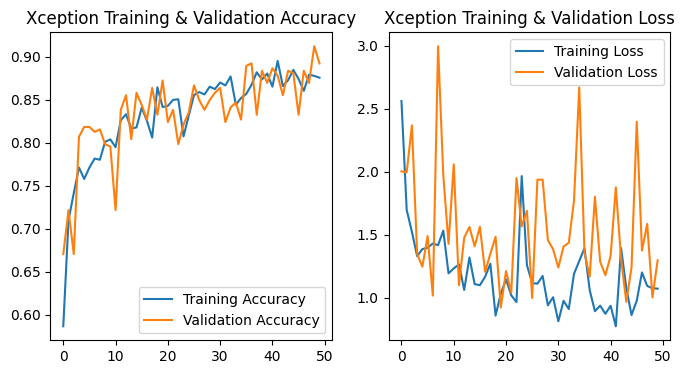

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc_x, label='Training Accuracy')
plt.plot(range(50), val_acc_x, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Xception Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss_x, label='Training Loss')
plt.plot(range(50), val_loss_x, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Xception Training & Validation Loss')
plt.show()

1/1 [==============================] - 0s 26ms/step


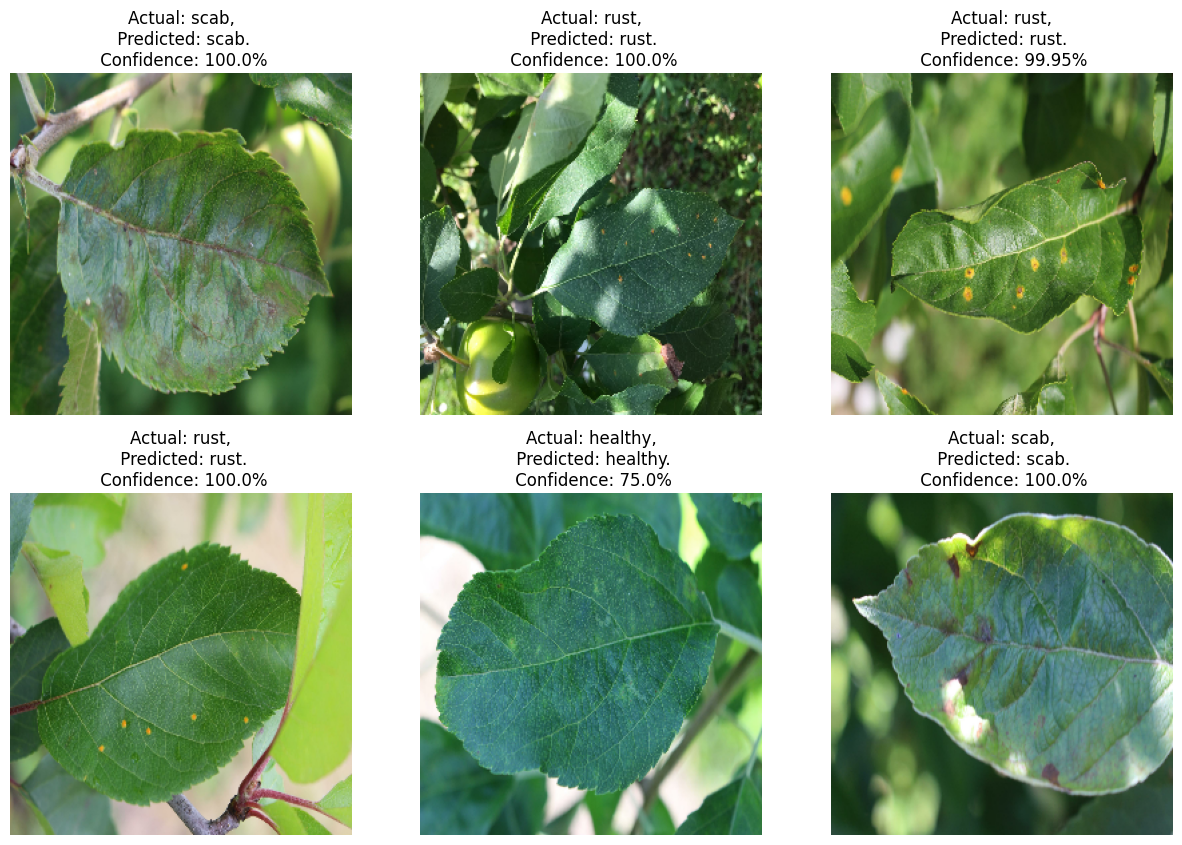

In [ ]:
plt.figure(figsize=(15, 10))
for images, labels in val_ds.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model_xcept, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### **MODEL TRAINING ResNet**

In [ ]:
from keras.applications.resnet_v2 import ResNet152V2

In [ ]:
resnet = ResNet152V2(include_top = False, 
                     weights = 'imagenet', 
                     input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS),
                     pooling='max')
resnet.trainable = False
print(resnet.summary())

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [ ]:
model_resnet = tf.keras.models.Sequential([
    resize_and_rescale,
    data_augmentation,
    resnet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

In [ ]:
model_resnet.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')
model_resnet.build(input_shape=(BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS))
print(model_resnet.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 resnet152v2 (Functional)    (None, 2048)              58331648  
                                                                 
 flatten_3 (Flatten)         (32, 2048)                0         
                                                                 
 dense_4 (Dense)             (32, 4)                   8196      
                                                                 
Total params: 58,339,844
Trainable params: 8,196
Non-trainable params: 58,331,648
_________________________________________________________________
None


In [ ]:
callback_hist_resnet = model_resnet.fit(
     train_ds,
     batch_size=BATCH_SIZE,
     epochs=50,
     validation_data=val_ds
     )

Epoch 1/50
45/45 [==============================] - 30s 414ms/step - loss: 3.1052 - accuracy: 0.4516 - val_loss: 1.9058 - val_accuracy: 0.6193
Epoch 2/50
45/45 [==============================] - 15s 328ms/step - loss: 1.5592 - accuracy: 0.6068 - val_loss: 1.3187 - val_accuracy: 0.6989
Epoch 3/50
45/45 [==============================] - 15s 332ms/step - loss: 1.2819 - accuracy: 0.6465 - val_loss: 1.1479 - val_accuracy: 0.7017
Epoch 4/50
45/45 [==============================] - 17s 379ms/step - loss: 1.1149 - accuracy: 0.6792 - val_loss: 1.0745 - val_accuracy: 0.6932
Epoch 5/50
45/45 [==============================] - 14s 322ms/step - loss: 1.0137 - accuracy: 0.7203 - val_loss: 0.9183 - val_accuracy: 0.7216
Epoch 6/50
45/45 [==============================] - 15s 325ms/step - loss: 0.9467 - accuracy: 0.7265 - val_loss: 0.9082 - val_accuracy: 0.7443
Epoch 7/50
45/45 [==============================] - 15s 330ms/step - loss: 0.9592 - accuracy: 0.7286 - val_loss: 0.9462 - val_accuracy: 0.7841

In [ ]:
acc_r = callback_hist_resnet.history['accuracy']
val_acc_r = callback_hist_resnet.history['val_accuracy']
loss_r = callback_hist_resnet.history['loss']
val_loss_r = callback_hist_resnet.history['val_loss']

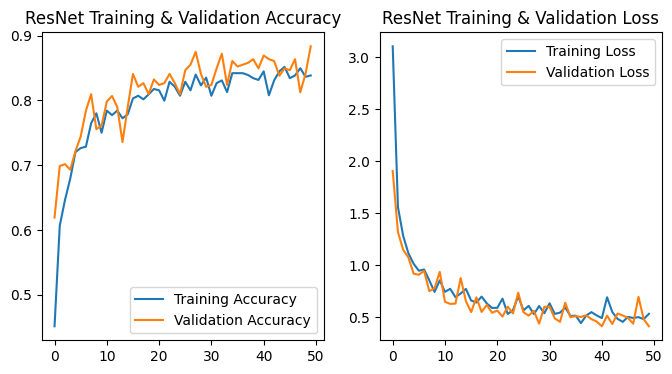

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc_r, label='Training Accuracy')
plt.plot(range(50), val_acc_r, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('ResNet Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss_r, label='Training Loss')
plt.plot(range(50), val_loss_r, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('ResNet Training & Validation Loss')
plt.show()

1/1 [==============================] - 0s 30ms/step


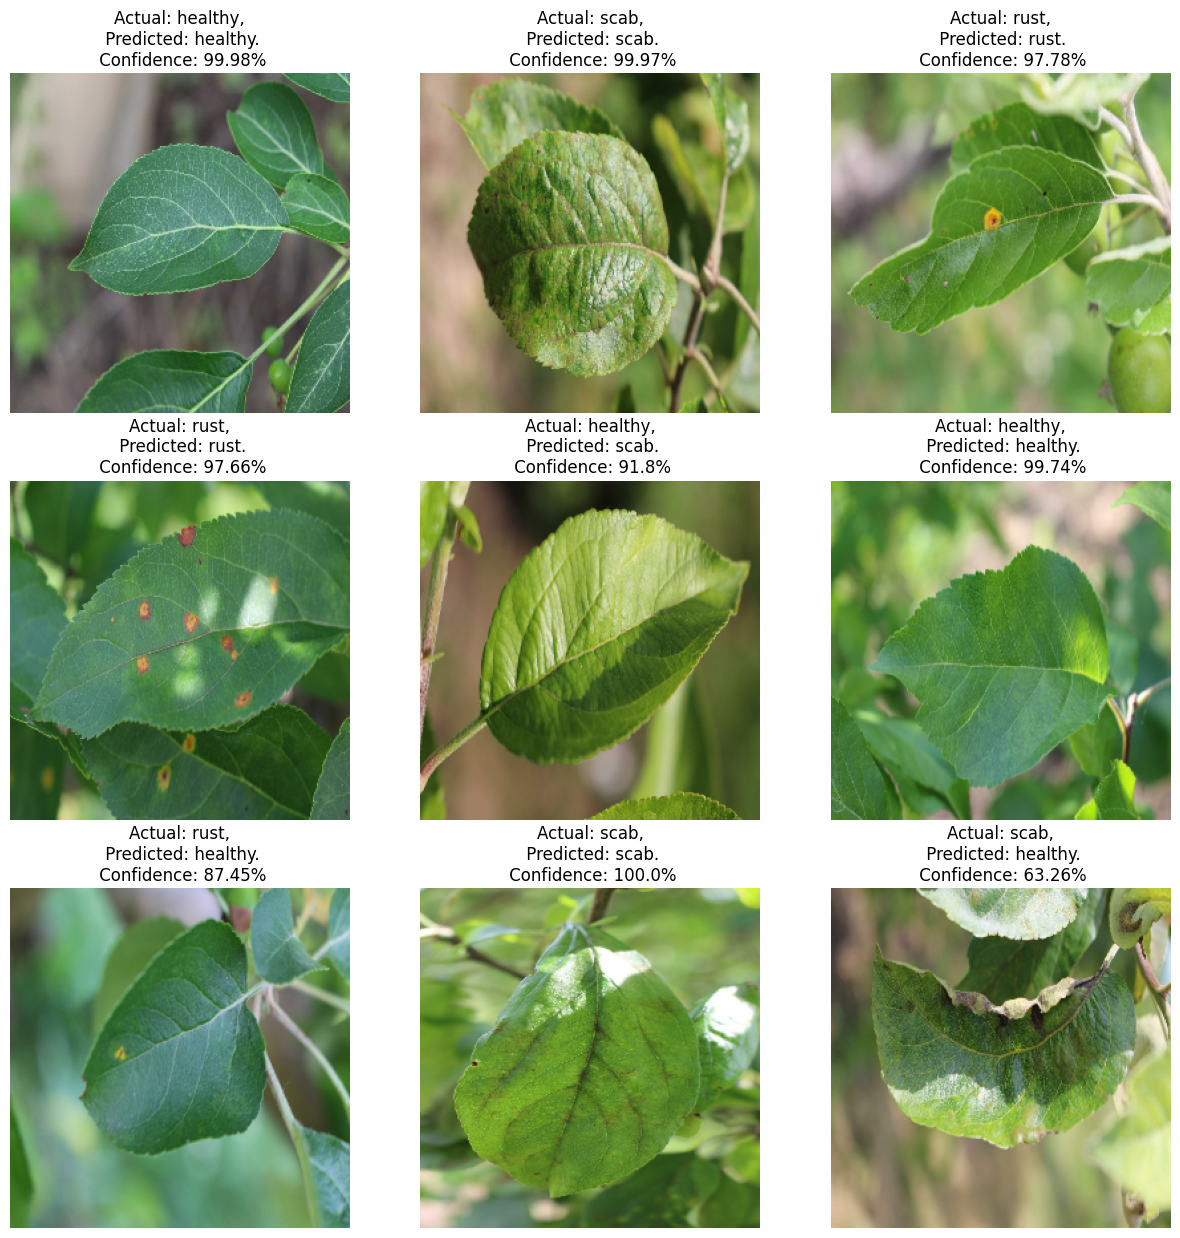

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model_resnet, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## **COMPARATIVE STUDY**

In [ ]:
predicted_ds_model=[]
predicted_ds_xcept=[]
predicted_ds_resnet=[]
actual_ds=[]

In [ ]:
for images, labels in val_ds:
  for i in range(len(images)):
      predicted_class,confidence= predict(model, images[i].numpy())
      predicted_class_x,confidence= predict(model_xcept,images[i].numpy())
      predicted_class_r,confidence= predict(model_resnet,images[i].numpy())
      actual_class = class_names[labels[i]]
      predicted_ds_model.append(predicted_class)
      predicted_ds_xcept.append(predicted_class_x)
      predicted_ds_resnet.append(predicted_class_r)
      actual_ds.append(actual_class)

In [ ]:
from sklearn import metrics

In [ ]:
confusion_matrix_m= metrics.confusion_matrix(actual_ds, predicted_ds_model)
confusion_matrix_x= metrics.confusion_matrix(actual_ds, predicted_ds_xcept)
confusion_matrix_r= metrics.confusion_matrix(actual_ds, predicted_ds_resnet)

In [ ]:
crm=metrics.classification_report(actual_ds,predicted_ds_model)
crx=metrics.classification_report(actual_ds,predicted_ds_xcept)
crr=metrics.classification_report(actual_ds,predicted_ds_resnet)

In [ ]:
print("Self Defined")
print(crm)
print("\nXcept")
print(crx)
print("\nResNet152v2")
print(crr)

Self Defined
                   precision    recall  f1-score   support

          healthy       0.95      0.98      0.96       108
multiple_diseases       0.75      0.19      0.30        16
             rust       0.95      0.98      0.97       120
             scab       0.94      0.97      0.95       108

         accuracy                           0.94       352
        macro avg       0.90      0.78      0.80       352
     weighted avg       0.94      0.94      0.93       352


Xcept
                   precision    recall  f1-score   support

          healthy       0.88      0.94      0.91       108
multiple_diseases       0.70      0.44      0.54        16
             rust       0.87      0.93      0.90       120
             scab       0.96      0.88      0.92       108

         accuracy                           0.89       352
        macro avg       0.85      0.79      0.81       352
     weighted avg       0.89      0.89      0.89       352


ResNet152v2
                 